In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from elpv_dataset.utils.elpv_reader import load_dataset

from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
transform = v2.Compose([
    v2.RandomVerticalFlip(0.5),
    v2.RandomHorizontalFlip(0.5),
])

transform_base = v2.Compose([
    # v2.Grayscale(num_output_channels=3),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((24,24), antialias=None),
])

In [3]:
class ELPV_Dataset(Dataset):
    def __init__(self, transform=None):
        images, labels, types = load_dataset()
        self.images = np.reshape(images, (np.shape(images)[0], np.shape(images)[1], np.shape(images)[2], 1))
        
        self.labels = (labels*3).astype(np.uint8)
        self.types = types
        self.transform = transform
        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            
            image = self.transform(image)
            
        return image, label

    def __len__(self):
        return (len(self.images))

data = ELPV_Dataset(transform_base)

In [4]:
batch_size = 128

val_size = int(len(data)*(1/4))
train_size = len(data) - val_size
print(f"Training Data: {train_size} Validation Data: {val_size}")

train_data, val_data = torch.utils.data.random_split(data,[train_size,val_size])

label_tensor = torch.Tensor([label for (image, label) in train_data]).int()
train_sampler = torch.utils.data.sampler.WeightedRandomSampler([(1/torch.bincount(label_tensor)[label].item()) for (image, label) in train_data],len(train_data))
label_tensor = torch.Tensor([label for (image, label) in val_data]).int()
val_sampler = torch.utils.data.sampler.WeightedRandomSampler([(1/torch.bincount(label_tensor)[label].item()) for (image, label) in val_data],len(val_data))

train_dl = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# for images, labels in val_dl:
#     print(torch.bincount(labels))

Training Data: 1968 Validation Data: 656


In [5]:
# i = np.random.randint(1,200)
print(np.shape(data[0][0]))
# print(data[i][0])
# # images, labels, types = load_dataset()

# # print(transform(images[0]))
# plt.imshow(data[i][0].permute(1,2,0))
# plt.show()

torch.Size([1, 24, 24])


In [6]:
class VGG7(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 1, (3,3), padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(1, 1, (3,3), padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),

            nn.MaxPool2d(2,2),
            
            nn.Conv2d(1, 2, (3,3), padding=1),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 2, (3,3), padding=1),
            nn.BatchNorm2d(2),
            nn.ReLU(),

            nn.MaxPool2d(2,2),
            
            nn.Conv2d(2, 512, (3,3), padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, (3,3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 4, (3,3), padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),

            nn.MaxPool2d(12,12),
            
            nn.Flatten(),

            nn.Linear(4,4),
            nn.LogSoftmax(-1),
        )
    def forward(self, x):
        output = self.network(x)
        return output

class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        multiplier = 4
        self.input = nn.Sequential(
            nn.Conv2d(1, 1*multiplier, (3,3), padding=1),
            nn.ReLU(),
        )
        self.block1 = self.block(1*multiplier,1*multiplier)
        self.block2 = self.block(1*multiplier,1*multiplier)
        self.block3 = self.block(1*multiplier,2*multiplier)
        self.block4 = self.block(2*multiplier,2*multiplier)
        self.block5 = self.block(2*multiplier,4*multiplier)
        self.block6 = self.block(4*multiplier,4*multiplier)
        self.block7 = self.block(4*multiplier,8*multiplier)
        self.block8 = self.block(8*multiplier,8*multiplier)

        self.maxpool = nn.MaxPool2d(2,2)
        self.globalmaxpool = nn.AvgPool2d(2,2)
        self.fc = nn.Linear(8*multiplier, 4)
        self.lsf = nn.LogSoftmax(-1)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(0)
 
    def block(self, input_channels, output_channels):
        output = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, (3,3), padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(),
            nn.Conv2d(output_channels, output_channels, (3,3), padding=1),
            nn.BatchNorm2d(output_channels),
        )
        return output

    def process_block(self, input, block, sample=None):
        result = block(input)

        if sample:
            input = self.sample(input)
        
        output = self.relu(input + result)

        return output

    def sample(self, input):
        in_c = int(input.size()[1])
        out_c = int(input.size()[1]*2)
        upsample = nn.Conv2d(in_c, out_c, (3,3), padding=1)
        upsample.to('cuda')
        output = upsample(input)
        return output
        
    def forward(self,x):
        x = self.input(x)
        x = self.process_block(x, self.block1)
        x = self.process_block(x, self.block2)
        x = self.maxpool(x)
        x = self.process_block(x, self.block3, True)
        x = self.process_block(x, self.block4)
        x = self.maxpool(x)
        x = self.process_block(x, self.block5, True)
        x = self.process_block(x, self.block6)
        x = self.maxpool(x)
        x = self.process_block(x, self.block7, True)
        x = self.process_block(x, self.block8)
        x = self.globalmaxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.lsf(x)

        return x

model = ResNet18()
model = model.to('cuda')

In [7]:
 # for i, (images, labels) in enumerate(train_dl):
        
 #        plt.imshow(images[0].permute(1,2,0))
 #        plt.show()
 #        images = transform(images)
 #        plt.imshow(images[0].permute(1,2,0))
 #        plt.show()
     

In [8]:
num_epochs = 5000

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

history = []

for epoch in range(num_epochs+1):
    model.train()

    loss_sum = 0
    batch_count = 0
    result = 0
    
    for i, (images, labels) in enumerate(train_dl):
        images = transform(images)
        images = images.to('cuda')
        labels = labels.to('cuda')
        
        outputs = model(images)
        losses = loss_fn(outputs, labels)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        predictions = (torch.argmax(outputs, dim=1))
        results = predictions - labels
        result+= len(np.where(results.cpu() == 0)[0])

        loss_sum+= losses.item()
        batch_count+=1

    train_loss = round((loss_sum/batch_count),4)
    train_accuracy = round((result/(batch_count*batch_size))*100,2)

    model.eval()
    
    loss_sum = 0
    batch_count = 0
    result = 0
        
    for i, (images, labels) in enumerate(val_dl):
        images = images.to('cuda')
        labels = labels.to('cuda')
 
        outputs = model(images)
        losses = loss_fn(outputs, labels)
        predictions = (torch.argmax(outputs, dim=1))
        results = predictions - labels
        result+= len(np.where(results.cpu() == 0)[0])

        loss_sum+= losses.item()
        batch_count+=1

    val_loss = round((loss_sum/batch_count),4)
    val_accuracy = round((result/(batch_count*batch_size))*100,2)

    history.append({'train_loss':train_loss,'train_acc':train_accuracy,'val_loss':val_loss,'val_acc':val_accuracy})

    print("Epoch [{}]/[{}], train_loss: {:4f}, train_acc: {:.2f}%, val_loss: {:4f}, val_acc: {:.2f}%".format(
        epoch, num_epochs, train_loss, train_accuracy, val_loss, val_accuracy))


Epoch [0]/[5000], train_loss: 1.408400, train_acc: 26.27%, val_loss: 1.429100, val_acc: 7.68%
Epoch [1]/[5000], train_loss: 1.358400, train_acc: 28.91%, val_loss: 1.524200, val_acc: 3.65%
Epoch [2]/[5000], train_loss: 1.307200, train_acc: 34.38%, val_loss: 1.499000, val_acc: 8.98%
Epoch [3]/[5000], train_loss: 1.270400, train_acc: 37.11%, val_loss: 1.363000, val_acc: 22.53%
Epoch [4]/[5000], train_loss: 1.286700, train_acc: 37.26%, val_loss: 1.277400, val_acc: 30.86%
Epoch [5]/[5000], train_loss: 1.241800, train_acc: 38.67%, val_loss: 1.339200, val_acc: 29.17%
Epoch [6]/[5000], train_loss: 1.245600, train_acc: 37.94%, val_loss: 1.391700, val_acc: 28.39%
Epoch [7]/[5000], train_loss: 1.227300, train_acc: 40.53%, val_loss: 1.292100, val_acc: 33.07%
Epoch [8]/[5000], train_loss: 1.238100, train_acc: 38.57%, val_loss: 1.451100, val_acc: 20.18%
Epoch [9]/[5000], train_loss: 1.232200, train_acc: 40.14%, val_loss: 1.109500, val_acc: 38.41%
Epoch [10]/[5000], train_loss: 1.217600, train_acc: 3

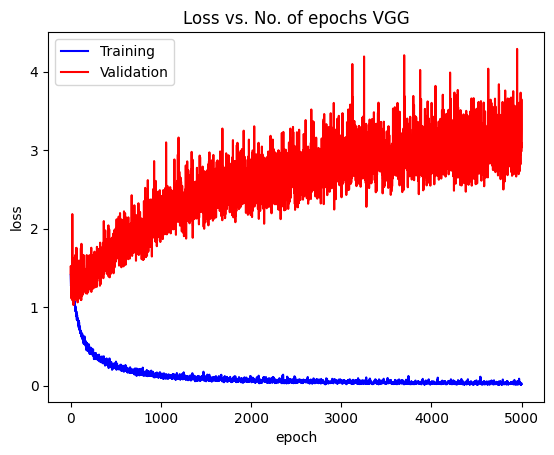

In [9]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs VGG');

plot_losses(history)

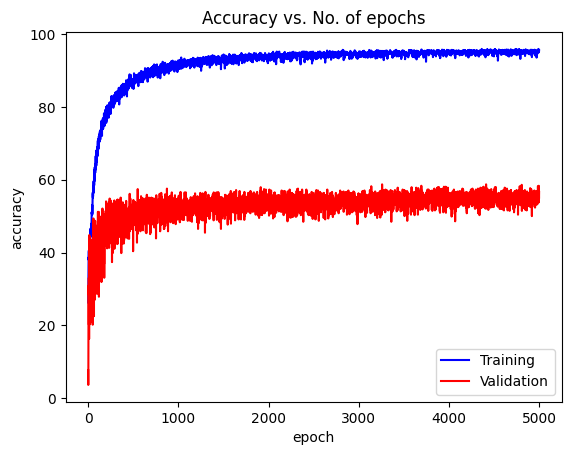

In [10]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    train_acc = [x['train_acc'] for x in history]
    val_acc = [x['val_acc'] for x in history]
    plt.plot(train_acc, '-b')
    plt.plot(val_acc, '-r')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
    
plot_accuracies(history)

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       374
           1       0.38      0.38      0.38        78
           2       0.08      0.04      0.05        28
           3       0.62      0.60      0.61       176

    accuracy                           0.65       656
   macro avg       0.45      0.45      0.45       656
weighted avg       0.63      0.65      0.64       656



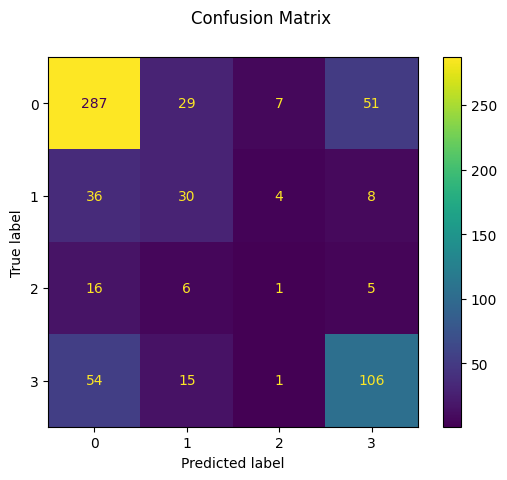

In [11]:
model.eval()
model = model.to('cuda')

label_list = []
prediction_list = []

data = ELPV_Dataset(transform_base)
dataloader = DataLoader(data, batch_size=1, shuffle=False)

for image, label in val_data:
    # print(image)
    image = torch.reshape(image, (1, np.shape(image)[0], np.shape(image)[1], np.shape(image)[2]))
    image = image.to('cuda')
    result = model(image)
    result = result.to('cpu')
    
    prediction_list.append(torch.argmax(result).item())
    label_list.append(label.item())
    # print(result.item())

# print((label_list))
# print((prediction_list))

print(metrics.classification_report(label_list, prediction_list))
disp = metrics.ConfusionMatrixDisplay.from_predictions(label_list, prediction_list)
disp.figure_.suptitle("Confusion Matrix")
plt.show()
    